# Using BigQuery to perform basic data analytics

Here's a sample notebook of executing SQL commands in order to analyze some data, along with some basic visualization.

We'll explore some data sets and reproduce how we might write queries for certain business problems.

### Setup

In [1]:
# relevant installs
# !pip install google-cloud 
# !pip install --upgrade google-cloud-bigquery[pandas] 
# !pip install google-cloud-storage

In [2]:
%load_ext google.cloud.bigquery

In [3]:
SERVICE_ACCOUNT= 'bq_jupyter'
JSON_FILE_NAME = '../credentials/ds-portfolio-a04fdb631b73.json'
GCP_PROJECT_ID = 'ds-portfolio'

In [4]:
import subprocess
import sys
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

logger = logging.Logger('catch_all')

def run_command(parameters):
    try:
        # """Prints and runs a command."""
        return subprocess.check_output(parameters)
    except BaseException as e: 
       logger.error(e) 
       logger.error('ERROR: Looking in jupyter console for more information')

In [5]:
%matplotlib inline

### Queries

We'll be using the San Francisco Bikeshares dataset, which contains information around trips for the bikeshare program in San Francisco.

In [6]:
from google.cloud import bigquery

client = bigquery.Client.from_service_account_json(JSON_FILE_NAME)

def query_to_df(query):
    # transfers query results to pandas dataframe for easy manipulating
    return(client.query(query).result().to_dataframe())

def get_schema(table):
    # retreives the schema as a printed object
    return(client.get_table(table).schema)

There's 4 different tables in this database. As a first step, we should look at the schema of all of these tables and see where we might be able to join for insight in future queries.

The tables are...
* bikeshare_regions
* bikeshare_station_info
* bikeshare_station_status
* bikeshare_trips

In [23]:
#bikeshare_regions
table = 'bigquery-public-data.san_francisco_bikeshare.bikeshare_regions'
get_schema(table)

[SchemaField('region_id', 'INTEGER', 'REQUIRED', 'Unique identifier for the region', ()),
 SchemaField('name', 'STRING', 'REQUIRED', 'Public name for this region', ())]

In [24]:
#bikeshare_station_info
table = 'bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info'
get_schema(table)

[SchemaField('station_id', 'INTEGER', 'REQUIRED', 'Unique identifier of a station.', ()),
 SchemaField('name', 'STRING', 'REQUIRED', 'Public name of the station', ()),
 SchemaField('short_name', 'STRING', 'NULLABLE', 'Short name or other type of identifier, as used by the data publisher', ()),
 SchemaField('lat', 'FLOAT', 'REQUIRED', 'The latitude of station. The field value must be a valid WGS 84 latitude in decimal degrees format. See: http://en.wikipedia.org/wiki/World_Geodetic_System, https://en.wikipedia.org/wiki/Decimal_degrees', ()),
 SchemaField('lon', 'FLOAT', 'REQUIRED', 'The longitude of station. The field value must be a valid WGS 84 longitude in decimal degrees format. See: http://en.wikipedia.org/wiki/World_Geodetic_System, https://en.wikipedia.org/wiki/Decimal_degrees', ()),
 SchemaField('region_id', 'INTEGER', 'NULLABLE', 'ID of the region where station is located', ()),
 SchemaField('rental_methods', 'STRING', 'NULLABLE', 'Array of enumerables containing the payment me

In [26]:
#bikeshare_station_status
table = 'bigquery-public-data.san_francisco_bikeshare.bikeshare_station_status'
get_schema(table)

[SchemaField('station_id', 'INTEGER', 'REQUIRED', 'Unique identifier of a station', ()),
 SchemaField('num_bikes_available', 'INTEGER', 'REQUIRED', 'Number of bikes available for rental', ()),
 SchemaField('num_bikes_disabled', 'INTEGER', 'NULLABLE', 'Number of disabled bikes at the station. Vendors who do not want to publicize the number of disabled bikes or docks in their system can opt to omit station capacity (in station_information), num_bikes_disabled and num_docks_disabled. If station capacity is published then broken docks/bikes can be inferred (though not specifically whether the decreased capacity is a broken bike or dock)', ()),
 SchemaField('num_docks_available', 'INTEGER', 'REQUIRED', 'Number of docks accepting bike returns', ()),
 SchemaField('num_docks_disabled', 'INTEGER', 'NULLABLE', 'Number of empty but disabled dock points at the station. This value remains as part of the spec as it is possibly useful during development', ()),
 SchemaField('is_installed', 'BOOLEAN', 

In [27]:
#bikeshare_trips
table = 'bigquery-public-data.san_francisco_bikeshare.bikeshare_trips'
get_schema(table)

[SchemaField('trip_id', 'INTEGER', 'REQUIRED', 'Numeric ID of bike trip', ()),
 SchemaField('duration_sec', 'INTEGER', 'NULLABLE', 'Time of trip in seconds', ()),
 SchemaField('start_date', 'TIMESTAMP', 'NULLABLE', 'Start date of trip with date and time, in PST', ()),
 SchemaField('start_station_name', 'STRING', 'NULLABLE', 'Station name of start station', ()),
 SchemaField('start_station_id', 'INTEGER', 'NULLABLE', 'Numeric reference for start station', ()),
 SchemaField('end_date', 'TIMESTAMP', 'NULLABLE', 'End date of trip with date and time, in PST', ()),
 SchemaField('end_station_name', 'STRING', 'NULLABLE', 'Station name for end station', ()),
 SchemaField('end_station_id', 'INTEGER', 'NULLABLE', 'Numeric reference for end station', ()),
 SchemaField('bike_number', 'INTEGER', 'NULLABLE', 'ID of bike used', ()),
 SchemaField('zip_code', 'STRING', 'NULLABLE', 'Home zip code of subscriber (customers can choose to manually enter zip at kiosk however data is unreliable)', ()),
 Schema

So when we take a look at the schemas, we can see that each table gives us some different information. A few things that jump out:
* We get some interesting information from the `station_info` table regarding payment types. It could be interesting to look if stations with different payment types are associated with more or less rides.
* The `bikeshare_trips` table will give us information around ride-by-ride stats and has unique identifiers around customers/members that use them.
    * We have additional information for members, but not for customers
    * This will allow us to take a look at where popular routes might be
    
At this point, we can probably start looking at doing some queries for some explorative work, and seeing where we might be able to answer questions for real business impact.

Let's start out by looking how many rides each of the bikes in our dataset have on them. This might give us an idea how much wear and tear these bikes have.

Text(0.5, 1.0, 'Number of rides per bike')

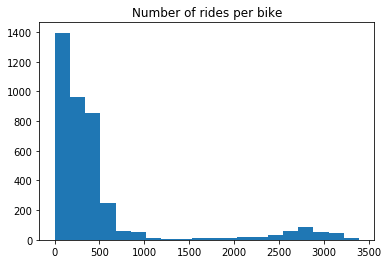

In [31]:
# q1
# which bikes have been used the most?
QUERY = (
    """
    SELECT
        COUNT(trip_id) AS num_trips, bike_number 
    FROM
      `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
    GROUP BY
      bike_number
    ORDER BY
      num_trips DESC
    """)


ret_df = query_to_df(QUERY)
plt.hist(ret_df.num_trips, bins = 20)
plt.title("Number of rides per bike")

So here we see that the distribution is not normal, and looks like there's two different fundamental groups that we're dealing with. We have one group of bikes that is used less than about 1000 times, and another normal-ish looking distribution centered around 2750. It might be interesting to look at the differences between these two groups of bikes- maybe they tend to be found on different routes? Maybe they have less miles on them, but just many more frequent rides?

We'll start off by looking at the differences between the average ride time between the many-rides group and the few-rides group.

Text(0, 0.5, 'Density/Frequency')

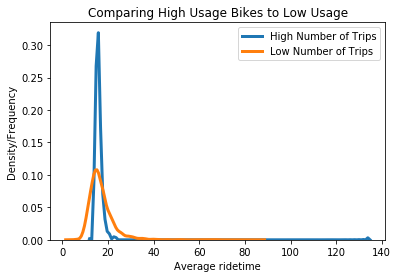

In [34]:
# q2
# compare average ride times for bikes above/below 1500 bikes

# high rides query
q2_a = (
    """
    SELECT
        avg(duration_sec)/60 AS avg_trip_length_min, 
        COUNT(trip_id) AS num_trips,
        bike_number 
    FROM
        `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
    GROUP BY
        bike_number
    HAVING
        num_trips >= 1500
    """)

ret_df_a = query_to_df(q2_a)

# low rides query
q2_b = (
    """
    SELECT
        avg(duration_sec)/60 AS avg_trip_length_min,
        COUNT(trip_id) AS num_trips,
        bike_number
    FROM
        `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
    GROUP BY
        bike_number
    HAVING
        num_trips < 1500
    """)

ret_df_b = query_to_df(q2_b)

# plot them on the same plot with density lines rather than histograms
sns.distplot(ret_df_a['avg_trip_length_min'], hist = False, kde = True,
            kde_kws = {'linewidth': 3},
            label = "High Number of Trips")
sns.distplot(ret_df_b['avg_trip_length_min'], hist = False, kde = True,
            kde_kws = {'linewidth': 3},
            label = "Low Number of Trips")
plt.legend(prop={'size':10})
plt.title("Comparing High Usage Bikes to Low Usage")
plt.xlabel("Average ridetime")
plt.ylabel("Density/Frequency")

So we can see that our bikes with lower number of trips have a higher variance around the average trip length, whereas the high usage bikes have much lower variance. This gives some evidence to our theory that perhaps the higher usage bikes are going on certain high-traffic routes (that presumably are around 17 minutes or so).

Note that I used a density plot instead of comparing histograms. From a data visualization perspective, we want these plotted on the same axes to make this comparison easy to make. Doing overlapping histograms can get cluttered, so we opt instead for the density plot which comes across much cleaner with the same kind of takeaway as the histogram.

In the query, we also use `HAVING` instead of `WHERE` since the condition is applied after our grouping aggregation.

Interestingly, the overall mean of both of these appear to be the same. We'll calculate some basic statics below to confirm.

In [37]:
# high usage
ret_df_a.describe()

,avg_trip_length_min,num_trips,bike_number
count,358.000000,358.000000,358.000000
mean,16.171550,2665.849162,438.709497
std,6.458857,409.004550,139.299144
min,13.069868,1517.000000,16.000000
25%,14.866111,2469.750000,349.250000
50%,15.545687,2754.000000,447.500000
75%,16.481781,2947.000000,545.500000
max,133.671334,3394.000000,878.000000


In [38]:
# low usage
ret_df_b.describe()

,avg_trip_length_min,num_trips,bike_number
count,3594.000000,3594.000000,3594.000000
mean,16.913051,276.306344,2152.675849
std,5.593865,205.036652,1090.074206
min,3.858333,1.000000,9.000000
25%,13.594331,114.250000,1276.250000
50%,15.837713,230.500000,2175.500000
75%,18.869190,416.000000,3076.750000
max,86.211910,1471.000000,4073.000000


A few more things to note...

* We have a lot more bikes in the low usage group compared to high usage group, by about 9x
* The means are pretty close, but the standard deviations are less similar. The higher usage has a higher variance but lower mean.
* We could run a t-test to see if the means are equal... with such large sample sizes we will likely come to the conclusion that they are in fact different. I'll skip over this for now.

Let's take a look into the routes used and see if this explains the differences.

In [20]:
# routes for high usage
# q3 
# maybe there's a more effecient way, but this works
q3_a = (
    """
    SELECT 
        SUM(num_trips) as trips,
        start_station_id,
        end_station_id
    FROM
        (SELECT
            COUNT(trip_id) AS num_trips,
            start_station_id,
            end_station_id,
            bike_number
         FROM
            `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
         WHERE
            bike_number IN 
                (SELECT bike_number
                 FROM
                    (SELECT 
                     COUNT(trip_id) AS num_trips,
                        bike_number
                     FROM
                        `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
                     GROUP BY
                        bike_number
                     HAVING
                        num_trips >= 1500
                    )
                )
         GROUP BY
            start_station_id, end_station_id, bike_number
        )
    GROUP BY
        start_station_id, end_station_id
    ORDER BY
        trips DESC
    LIMIT 25
    """)

high_vol_routes = query_to_df(q3_a)
high_vol_routes

,trips,start_station_id,end_station_id
0,8749,50,60
1,8168,69,65
2,7281,61,50
3,6601,50,61
4,6568,65,69
5,6557,60,74
6,6065,51,70
7,5930,70,50
8,5790,74,61
9,5714,74,70


In [21]:
# routes for low usage
# q3 
# maybe there's a more effecient way, but this works
q3_b = (
    """
    SELECT 
        SUM(num_trips) as trips,
        start_station_id,
        end_station_id
    FROM
        (SELECT
            COUNT(trip_id) AS num_trips,
            start_station_id,
            end_station_id,
            bike_number
         FROM
            `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
         WHERE
            bike_number IN 
                (SELECT bike_number
                 FROM
                    (SELECT 
                     COUNT(trip_id) AS num_trips,
                        bike_number
                     FROM
                        `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
                     GROUP BY
                        bike_number
                     HAVING
                        num_trips < 1500
                    )
                )
         GROUP BY
            start_station_id, end_station_id, bike_number
        )
    GROUP BY
        start_station_id, end_station_id
    ORDER BY
        trips DESC
    LIMIT 25
    """)

low_vol_routes = query_to_df(q3_b)
low_vol_routes

,trips,start_station_id,end_station_id
0,4930,15,6
1,3758,28,27
2,3444,27,28
3,3129,4,2
4,3096,2,4
5,2872,6,16
6,2716,81,15
7,2469,32,28
8,2468,6,15
9,2277,15,81


Let's do some pandas trickery now that we've gotten the data from our database as a comparison.

In [41]:
high_vol_routes['route_coding'] = high_vol_routes.start_station_id.astype(str) + \
    "_" + high_vol_routes.end_station_id.astype(str)
low_vol_routes['route_coding'] = low_vol_routes.start_station_id.astype(str) + \
    "_" + low_vol_routes.end_station_id.astype(str)

high_vol_routes['in_low'] = high_vol_routes['route_coding'].\
    isin({'route_coding': low_vol_routes.route_coding.values.tolist()})
high_vol_routes

,trips,start_station_id,end_station_id,route_coding,in_low
0,8749,50,60,50_60,False
1,8168,69,65,69_65,False
2,7281,61,50,61_50,False
3,6601,50,61,50_61,False
4,6568,65,69,65_69,False
5,6557,60,74,60_74,False
6,6065,51,70,51_70,False
7,5930,70,50,70_50,False
8,5790,74,61,74_61,False
9,5714,74,70,74_70,False


Interestingly, none of the top 25 routes for the high volume bikes are in the top 25 low volume bike routes. While we could drill a bit deeper into this, with an initial analysis we see evidence that our bikes that have the most rides are fundamentally going on different routes for the higher volume bikes and lower volume bikes. This might be an interesting business result if the company is experiencing inequal wear and tear on the bikes- perhaps bikes from the lower volume routes could be moved to the higher ones and vice versa for more equal wear. Of course, more detailed analysis on a station-by-station level rather than route-level would be warranted in this case.

Let's pivot a little more to looking at some of our customers and subscribers.

I want to take a look at the cumulative minutes spent on bike rides by our highest usage customer on a month-by-month basis for 2018.

In [ ]:
QUERY = (
    """
    SELECT
      EXTRACT(YEAR
      FROM
        start_date) AS year,
      ROUND(AVG(duration_sec/60), 2) AS avg_duration_min,
      COUNT(*) AS yearly_trips
    FROM
      `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
    GROUP BY
      YEAR
    ORDER BY
      YEAR DESC
    """)

ret_df = client.query(QUERY).result().to_dataframe()
ret_df